# Predicting T1D using Machine Learning Algorithms

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import shap

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data Preprocessing

In [2]:
# load dataset and labels
data_file_path = "/content/diabetes_Dataset_Team_ML.csv"
labels_file_path = "/content/Diabetes_T1_labels.txt"
data = pd.read_csv(data_file_path)
labels = pd.read_csv(labels_file_path, delimiter='\t')

In [3]:
# preview dataset
print(data.head())

        ID  Ancestry_African  Ancestry_Any other Asian background  \
0  5713894               0.0                                  0.0   
1  2048882               0.0                                  0.0   
2  1748132               0.0                                  0.0   
3  3772083               0.0                                  0.0   
4  4376107               0.0                                  0.0   

   Ancestry_Any other Black background  Ancestry_Any other mixed background  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   Ancestry_Any other white background  Ancestry_Asian or Asian British  \
0                                  

In [4]:
# preview labels
print(labels.head())

    UKB ID  time_window_incident/nan/1.0/nan/av1  \
0  5713894                                   0.0   
1  2048882                                   0.0   
2  1748132                                   0.0   
3  3772083                                   0.0   
4  4376107                                   0.0   

   time_window_incident/nan/2.0/nan/av1  time_window_incident/nan/3.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   time_window_incident/nan/4.0/nan/av1  time_window_incident/nan/5.0/nan/av1  \
0                                   0.0                                   0.0   
1                                   0.

In [5]:
# filter for british ancestry
data = data[data['Ancestry_British'] == 1]

In [6]:
# how many british ancestry patients
int(data['Ancestry_British'].sum())

442574

In [7]:
# drop nan values from data
data = data.dropna()

In [8]:
# join dataset based on patient ids
# use left join to keep filtered data
joined_data = pd.merge(data, labels[['UKB ID', 'time_window_incident/nan/10.0/nan/av1']], left_on='ID', right_on='UKB ID', how='left')

In [9]:
# drop ukb id column
joined_data = joined_data.drop(columns=['UKB ID'])

In [10]:
# drop nan values
joined_data = joined_data.dropna(subset=['time_window_incident/nan/10.0/nan/av1'])

In [11]:
# list of joined dataset columns
print(list(joined_data.columns))

['ID', 'Ancestry_African', 'Ancestry_Any other Asian background', 'Ancestry_Any other Black background', 'Ancestry_Any other mixed background', 'Ancestry_Any other white background', 'Ancestry_Asian or Asian British', 'Ancestry_Bangladeshi', 'Ancestry_Black or Black British', 'Ancestry_British', 'Ancestry_Caribbean', 'Ancestry_Chinese', 'Ancestry_Do not know', 'Ancestry_Indian', 'Ancestry_Irish', 'Ancestry_Mixed', 'Ancestry_Other ethnic group', 'Ancestry_Pakistani', 'Ancestry_Prefer not to answer', 'Ancestry_White', 'Ancestry_White and Asian', 'Ancestry_White and Black African', 'Ancestry_White and Black Caribbean', 'f.21022.0.0', 'f.21001.0.0', 'f.904.0.0', 'f.904.0.0_Do not know', 'f.904.0.0_Prefer not to answer', 'f.20107_Father_Lung cancer', 'f.20107_Father_Bowel cancer', 'f.20107_Father_Prostate cancer', 'f.20107_Father_High blood pressure', 'f.20107_Father_Diabetes', 'f.20110_Mother_Lung cancer', 'f.20110_Mother_Bowel cancer', 'f.20110_Mother_Breast cancer', 'f.20110_Mother_High 

In [12]:
# dict mapping original column names to their descriptive names
column_renames = {
    'f.21022.0.0': 'Age',
    'f.21001.0.0': 'BMI',
    'f.20107_Father_Diabetes': 'Father has diabetes',
    'f.20110_Mother_Diabetes': 'Mother has diabetes',
    'f.20116.0.0_Current': 'Current smoker',
    'f.20116.0.0_Previous': 'Former smoker',
    'f.20116.0.0_Never': 'Never smoker',
    'f.6155_Vitamin D': 'Vitamin D',
    'f.6145_Death of a close relative': 'Death of family member',
    'f.6145_Serious illness, injury or assault to yourself': 'Serious illness, injury or assault to yourself',
    'f.6145_Serious illness, injury or assault of a close relative': 'Serious illness, injury or assault of a close relative',
    'f.6145_Financial difficulties': 'Financial difficulties',
    'f.6145_Marital separation/divorce': 'Marital separation/divorce',
    'f.6145_Death of a spouse or partner': 'Death of a spouse or partner'
}


In [13]:
# only keep renamed columns in dataframe
filtered_joined_data = joined_data[list(column_renames.keys())]
print(list(filtered_joined_data.columns))

['f.21022.0.0', 'f.21001.0.0', 'f.20107_Father_Diabetes', 'f.20110_Mother_Diabetes', 'f.20116.0.0_Current', 'f.20116.0.0_Previous', 'f.20116.0.0_Never', 'f.6155_Vitamin D', 'f.6145_Death of a close relative', 'f.6145_Serious illness, injury or assault to yourself', 'f.6145_Serious illness, injury or assault of a close relative', 'f.6145_Financial difficulties', 'f.6145_Marital separation/divorce', 'f.6145_Death of a spouse or partner']


In [14]:
# rename columns
filtered_joined_data = filtered_joined_data.rename(columns=column_renames)

In [15]:
# create family history feature

# combine 'Father has diabetes' and 'Mother has diabetes' into 'Family history'
filtered_joined_data['Family history'] = ((filtered_joined_data['Father has diabetes'] == 1) | (filtered_joined_data['Mother has diabetes'] == 1)).astype(int)

# drop the original parent diabetes columns
filtered_joined_data = filtered_joined_data.drop(columns=['Father has diabetes', 'Mother has diabetes'])

In [16]:
# create stress feature

stress_columns = [
    'Death of family member',
    'Serious illness, injury or assault to yourself',
    'Serious illness, injury or assault of a close relative',
    'Financial difficulties',
    'Marital separation/divorce',
    'Death of a spouse or partner'
]

# combine all stress columns in one binary feature
filtered_joined_data['stress'] = filtered_joined_data[stress_columns].max(axis=1).astype(int)

# drop the original individual stress columns
filtered_joined_data = filtered_joined_data.drop(columns=stress_columns)

In [17]:
# create smoking feature

# 1 for current smokers, 0 for former smokers, -1 for never smokers
filtered_joined_data['smoking'] = filtered_joined_data.apply(
    lambda row: 1 if row['Current smoker'] == 1 else (0 if row['Former smoker'] == 1 else -1), axis=1
).astype(int)

# drop the original smoking related columns
filtered_joined_data = filtered_joined_data.drop(columns=['Current smoker', 'Never smoker', 'Former smoker'])


In [18]:
# scaling age and bmi
scaler = StandardScaler()
filtered_joined_data[['Age', 'BMI']] = scaler.fit_transform(filtered_joined_data[['Age', 'BMI']])

In [19]:
# convert the vitamin d column to integers
filtered_joined_data['Vitamin D'] = filtered_joined_data['Vitamin D'].astype(int)

In [20]:
# add target column to dataframe
filtered_joined_data['target'] = joined_data['time_window_incident/nan/10.0/nan/av1'].astype(int)

# verify dataframe changes
print(filtered_joined_data.head())

        Age       BMI  Vitamin D  Family history  stress  smoking  target
0  0.420212  1.473980          0               0       1       -1       0
1 -0.329852 -1.005537          1               1       1       -1       0
2  0.920254 -0.886758          0               0       0       -1       0
3 -1.204926 -0.810400          0               0       0       -1       0
4  1.420296 -0.574962          0               0       1       -1       0


In [21]:
# how many patients have T1D
label_counts = filtered_joined_data['target'].value_counts()
print(label_counts)

target
0    417017
1      2777
Name: count, dtype: int64


In [22]:
# train test split

# seperate features and target
X = filtered_joined_data.drop(columns=['target'])
y = filtered_joined_data['target']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [ ]:
# # scaling age and bmi
# scaler = StandardScaler()
# X_train[['age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
# X_test[['age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

In [ ]:
# # address class imbalance

# # apply smote
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # check values after smote
# print("class distribution after smote:")
# print(pd.Series(y_train_resampled).value_counts())

## Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=300, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_prob))

Accuracy: 0.710065984325745
Confusion Matrix:
 [[88865 36241]
 [  273   560]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83    125106
           1       0.02      0.67      0.03       833

    accuracy                           0.71    125939
   macro avg       0.51      0.69      0.43    125939
weighted avg       0.99      0.71      0.82    125939

AUC:
 0.7484946067055666


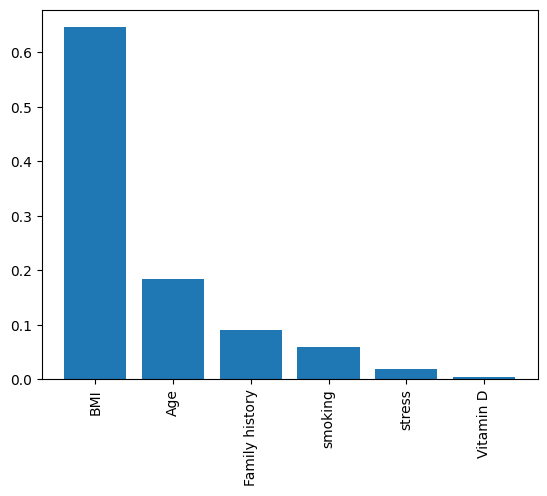

In [ ]:
# check feature importance
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.show()

In [ ]:
# perform random search to find best parameters

# parameter combinations
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

rf = RandomForestClassifier(random_state=42)

# random search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params,
    n_iter=20,  # number of combinations
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# fit
random_search.fit(X_train, y_train)

# get best paramenters for model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_
print("best parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END class_weight={0: 1, 1: 5}, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   8.4s
[CV] END class_weight={0: 1, 1: 5}, max_depth

In [ ]:
# # Perform Grid Search on Random Forest Model
# rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Avg AUC:", grid_search.best_score_) #Avg Score on 5 fold cross validation across all folds
# print("----------")
# print("\n\n\n")

# # Evaluate the model with the best hyperparameters on the test set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# y_prob = best_model.predict_proba(X_test)[:, 1]

# # Print evaluation metrics
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("AUC:\n", roc_auc_score(y_test, y_prob))

KeyboardInterrupt: 

Neural Network

Starting feature selection process...


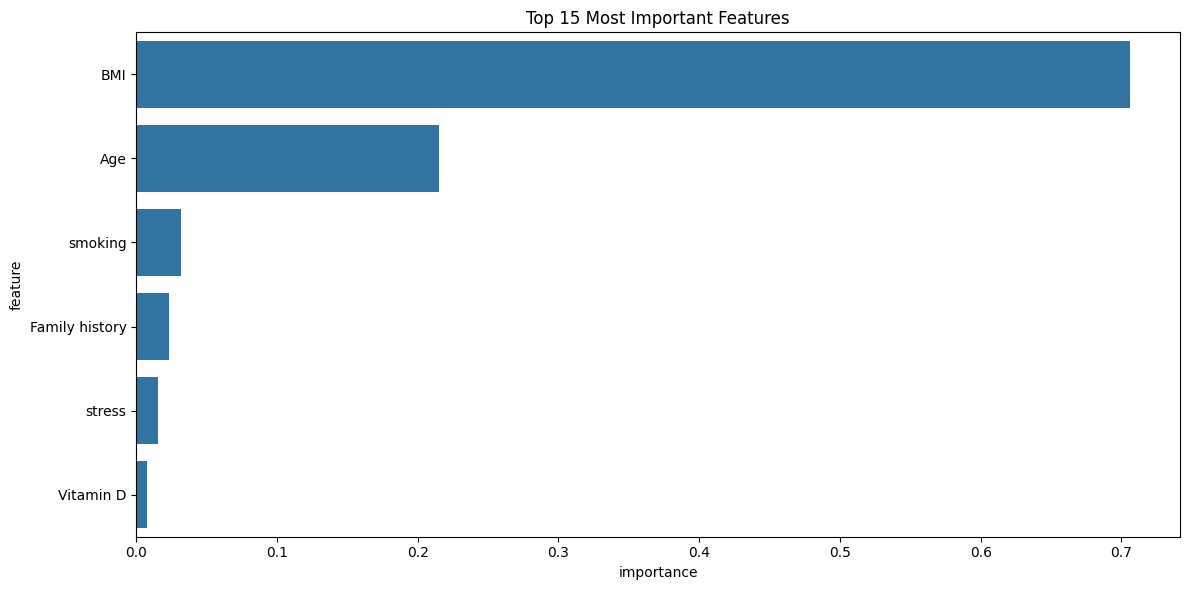

Performing RFECV...


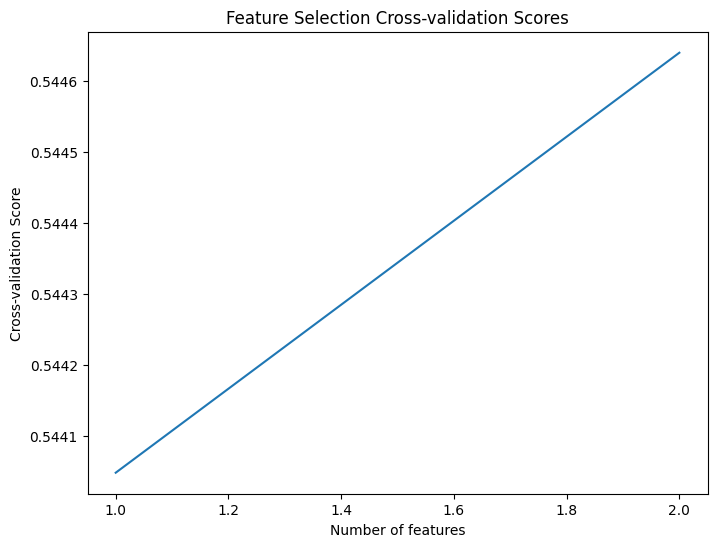


Selected 6 features:
['Age', 'BMI', 'Vitamin D', 'Family history', 'stress', 'smoking']

Feature Importance Analysis:
BMI: Selected (Importance: 0.7063)
Age: Selected (Importance: 0.2154)
smoking: Selected (Importance: 0.0318)
Family history: Selected (Importance: 0.0231)
stress: Selected (Importance: 0.0155)
Vitamin D: Selected (Importance: 0.0078)
Using device: cuda

Starting training...
Epoch [10/100], Loss: 1.3151
Epoch [20/100], Loss: 1.3100
Epoch [30/100], Loss: 1.3127
Early stopping at epoch 33


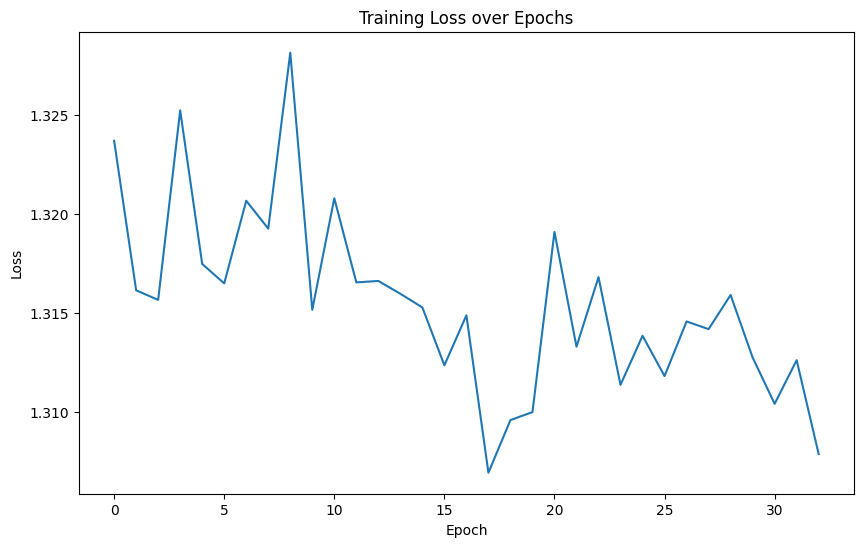


Evaluating model...


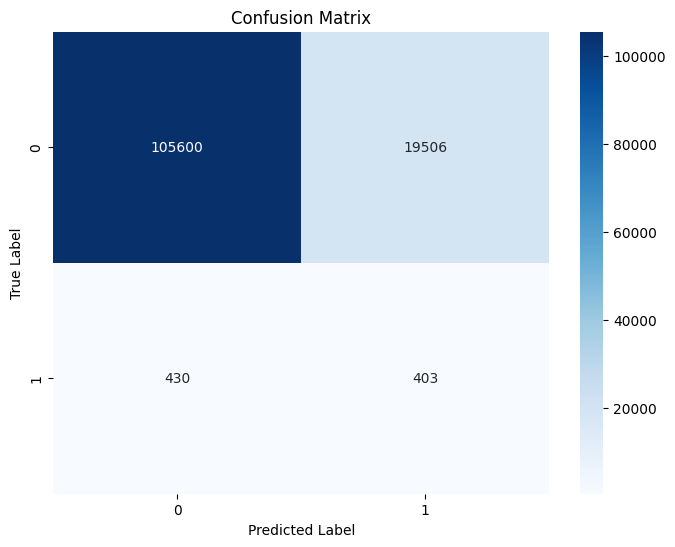


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91    125106
         1.0       0.02      0.48      0.04       833

    accuracy                           0.84    125939
   macro avg       0.51      0.66      0.48    125939
weighted avg       0.99      0.84      0.91    125939


ROC AUC Score: 0.7303361035556134


In [23]:
def perform_feature_selection(X_train, y_train, X_test):
    """
    Perform feature selection using both RFE and Random Forest importance
    """
    print("Starting feature selection process...")

    # Initialize Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    # Get feature importance from Random Forest
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(15))
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()

    # Select features using RFECV
    rfe = RFECV(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        step=1,
        cv=StratifiedKFold(5),
        scoring='roc_auc',
        min_features_to_select=5,
        n_jobs=-1
    )

    print("Performing RFECV...")
    rfe.fit(X_train, y_train)

    # Plot CV scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1),
            rfe.cv_results_['mean_test_score'])
    plt.xlabel('Number of features')
    plt.ylabel('Cross-validation Score')
    plt.title('Feature Selection Cross-validation Scores')
    plt.show()

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    print(f"\nSelected {len(selected_features)} features:")
    print(selected_features.tolist())

    # Compare RF importance with RFE selection
    print("\nFeature Importance Analysis:")
    for feat in importance['feature'][:10]:
        status = "Selected" if feat in selected_features else "Not Selected"
        print(f"{feat}: {status} (Importance: {importance[importance['feature']==feat]['importance'].values[0]:.4f})")

    # Return filtered datasets
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    return X_train_selected, X_test_selected, selected_features

class T1DPredictionNet(nn.Module):
    def __init__(self, input_dim):
        super(T1DPredictionNet, self).__init__()
        # Larger architecture with residual connections
        self.layer1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.layer4 = nn.Linear(64, 32)
        self.batch_norm4 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass with residual connections
        x1 = self.relu(self.batch_norm1(self.layer1(x)))
        x1 = self.dropout(x1)

        x2 = self.relu(self.batch_norm2(self.layer2(x1)))
        x2 = self.dropout(x2)

        x3 = self.relu(self.batch_norm3(self.layer3(x2)))
        x3 = self.dropout(x3)

        x4 = self.relu(self.batch_norm4(self.layer4(x3)))
        x4 = self.dropout(x4)

        out = self.sigmoid(self.output(x4))
        return out

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    print("\nStarting training...")
    train_losses = []
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss/len(train_loader)
        train_losses.append(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_prob = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = (outputs >= 0.5).float()

            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_prob.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_prob = np.array(y_pred_prob)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nROC AUC Score:", roc_auc_score(y_true, y_pred_prob))

    return y_pred_prob

def run_pipeline(X_train, X_test, y_train, y_test):
    # Perform feature selection
    X_train_selected, X_test_selected, selected_features = perform_feature_selection(X_train, y_train, X_test)

    # Create dataloaders with smaller batch size for imbalanced dataset
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train_selected.values),
            torch.FloatTensor(y_train.values).reshape(-1, 1)
        ),
        batch_size=16,  # Smaller batch size
        shuffle=True
    )

    test_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test_selected.values),
            torch.FloatTensor(y_test.values).reshape(-1, 1)
        ),
        batch_size=16,
        shuffle=False
    )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model
    model = T1DPredictionNet(len(selected_features)).to(device)

    # Calculate class weights
    n_samples = len(y_train)
    n_positive = sum(y_train)
    pos_weight = (n_samples - n_positive) / n_positive
    class_weight = torch.FloatTensor([pos_weight]).to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train model
    train_model(model, train_loader, criterion, optimizer, device)

    # Evaluate model
    print("\nEvaluating model...")
    predictions = evaluate_model(model, test_loader, device)

    return model, selected_features, predictions

# Run the complete pipeline
model, selected_features, predictions = run_pipeline(X_train, X_test, y_train, y_test)

Starting feature selection process...

Selected 6 features:
['BMI', 'Age', 'Family history', 'smoking', 'stress', 'Vitamin D']
Using device: cuda

Starting training...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150], Loss: 1.0065
Epoch [20/150], Loss: 1.0061
Epoch [30/150], Loss: 1.0054
Epoch [40/150], Loss: 1.0056
Epoch [50/150], Loss: 1.0050
Epoch [60/150], Loss: 1.0045
Epoch [70/150], Loss: 1.0048
Epoch [80/150], Loss: 1.0046
Epoch [90/150], Loss: 1.0047
Early stopping at epoch 93

Evaluating model...


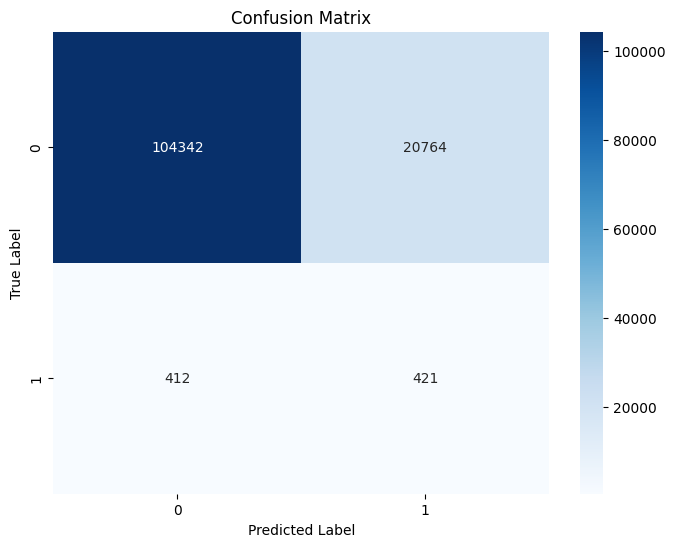


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    125106
         1.0       0.02      0.51      0.04       833

    accuracy                           0.83    125939
   macro avg       0.51      0.67      0.47    125939
weighted avg       0.99      0.83      0.90    125939


ROC AUC Score: 0.7446004155822801


In [24]:
def perform_feature_selection(X_train, y_train, X_test):
    """
    Perform feature selection using both RFE and Random Forest importance
    """
    print("Starting feature selection process...")

    # Initialize Random Forest with stronger class balance handling
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced_subsample',
        max_depth=10
    )
    rf.fit(X_train, y_train)

    # Get feature importance from Random Forest
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Select top 6 features based on importance
    selected_features = importance['feature'].head(6).tolist()
    print(f"\nSelected {len(selected_features)} features:")
    print(selected_features)

    # Return filtered datasets
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    return X_train_selected, X_test_selected, selected_features

class T1DPredictionNet(nn.Module):
    def __init__(self, input_dim):
        super(T1DPredictionNet, self).__init__()

        # Adjusted architecture for smaller input dimension
        self.layer1 = nn.Linear(input_dim, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.layer3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.relu(self.batch_norm1(self.layer1(x)))
        x1 = self.dropout(x1)

        x2 = self.relu(self.batch_norm2(self.layer2(x1)))
        x2 = self.dropout(x2)

        x3 = self.relu(self.batch_norm3(self.layer3(x2)))
        x3 = self.dropout(x3)

        out = self.sigmoid(self.output(x3))
        return out

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=150):
    print("\nStarting training...")
    train_losses = []
    best_loss = float('inf')
    patience = 20
    patience_counter = 0

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Mixup augmentation
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            index = torch.randperm(batch_X.size(0)).to(device)
            mixed_x = lam * batch_X + (1 - lam) * batch_X[index]
            mixed_y = lam * batch_y + (1 - lam) * batch_y[index]

            optimizer.zero_grad()
            outputs = model(mixed_x)
            loss = criterion(outputs, mixed_y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(train_loader)
        train_losses.append(avg_loss)

        scheduler.step(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_prob = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = (outputs >= 0.5).float()

            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_prob.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_prob = np.array(y_pred_prob)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nROC AUC Score:", roc_auc_score(y_true, y_pred_prob))

    return y_pred_prob

def run_pipeline(X_train, X_test, y_train, y_test):
    # SMOTE oversampling
    smote = SMOTE(random_state=42, sampling_strategy=0.3)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Feature selection
    X_train_selected, X_test_selected, selected_features = perform_feature_selection(
        pd.DataFrame(X_train_resampled, columns=X_train.columns),
        y_train_resampled,
        X_test
    )

    # Create dataloaders
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train_selected.values),
            torch.FloatTensor(y_train_resampled.values).reshape(-1, 1)
        ),
        batch_size=32,
        shuffle=True
    )

    test_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test_selected.values),
            torch.FloatTensor(y_test.values).reshape(-1, 1)
        ),
        batch_size=32,
        shuffle=False
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = T1DPredictionNet(len(selected_features)).to(device)

    # Calculate class weights
    n_samples = len(y_train_resampled)
    n_positive = sum(y_train_resampled)
    pos_weight = (n_samples - n_positive) / n_positive
    class_weight = torch.FloatTensor([pos_weight]).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        amsgrad=True
    )

    # Train model
    model = train_model(model, train_loader, criterion, optimizer, device)

    print("\nEvaluating model...")
    predictions = evaluate_model(model, test_loader, device)

    return model, selected_features, predictions

# Run the complete pipeline
model, selected_features, predictions = run_pipeline(X_train, X_test, y_train, y_test)